In [1]:
import sys
sys.path.append('..')
import os
import shutil
import numpy as np
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import random
import seaborn as sns
import pandas as pd
import pickle

from multiprocess import Pool
from program.helper import *
from program.mlp_optimization import *
from program.utility import *

import torch
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import KFold

In [2]:
with open('../program/label_translator.pkl', 'rb') as pkl_file:
    label_translator = pickle.load(pkl_file)

In [8]:
# Define a Composal of image transformation used for image load
transform_images = Compose([Resize((128, 128)), 
                            ToTensor()])

In [9]:
train_data = ImageFolder("data/train", transform=transform_images)
test_data = ImageFolder("data/test", transform=transform_images)

In [10]:
label_translator = dict(
    zip([*train_data.class_to_idx.values()], [*train_data.class_to_idx.keys()])
)
label_translator

{0: 'abstract',
 1: 'aerial',
 2: 'animals',
 3: 'black and white',
 4: 'celebrities',
 5: 'city and architecture',
 6: 'commercial',
 7: 'concert',
 8: 'family',
 9: 'fashion',
 10: 'film',
 11: 'fine art',
 12: 'food',
 13: 'journalism',
 14: 'landscapes',
 15: 'macro',
 16: 'nature',
 17: 'night',
 18: 'people',
 19: 'performing arts',
 20: 'sport',
 21: 'still life',
 22: 'street',
 23: 'transportation',
 24: 'travel',
 25: 'underwater',
 26: 'urban exploration',
 27: 'wedding'}

In [16]:
with open('./program/label_translator.pkl', 'wb') as pkl_file:
    pickle.dump(label_translator, pkl_file)

In [11]:
# Test size
train_size = len(train_data.targets) / (
    len(train_data.targets) + len(test_data.targets)
)
print("Train Size in Folder: ", train_size)

Train Size in Folder:  0.8995574437953621


In [12]:
dataloader_train = DataLoader(train_data, batch_size=128, shuffle=True, 
                              num_workers=24, pin_memory=True)
dataloader_test = DataLoader(test_data, batch_size=128, shuffle=True, 
                             num_workers=24, pin_memory=True)

In [13]:
# Plot some images
images, labels = next(iter(dataloader_train))

In [14]:
def plot_images_from_loader(
    images_from_loader: list, labels: list, amount: int, **args
):
    """"""
    plot_idx = np.random.permutation(np.arange(0, len(images_from_loader)))[:amount]
    plot_images = images_from_loader[plot_idx]
    plot_images = [to_pil_image(img) for img in plot_images]
    plot_images_labels = labels[plot_idx]

    ncol = args.get("ncol", None) if args.get("ncol", None) else 5
    nrow = int(amount / ncol) + 1
    fig = plt.subplots(figsize=(20, 4 * nrow))
    for i, img_label in enumerate(zip(plot_images, plot_images_labels)):
        plt.subplot(nrow, ncol, i + 1)
        plt.imshow(img_label[0])
        plt.title(
            f"Label: {img_label[1].tolist()} / {label_translator[img_label[1].tolist()]}"
        )
    plt.show()

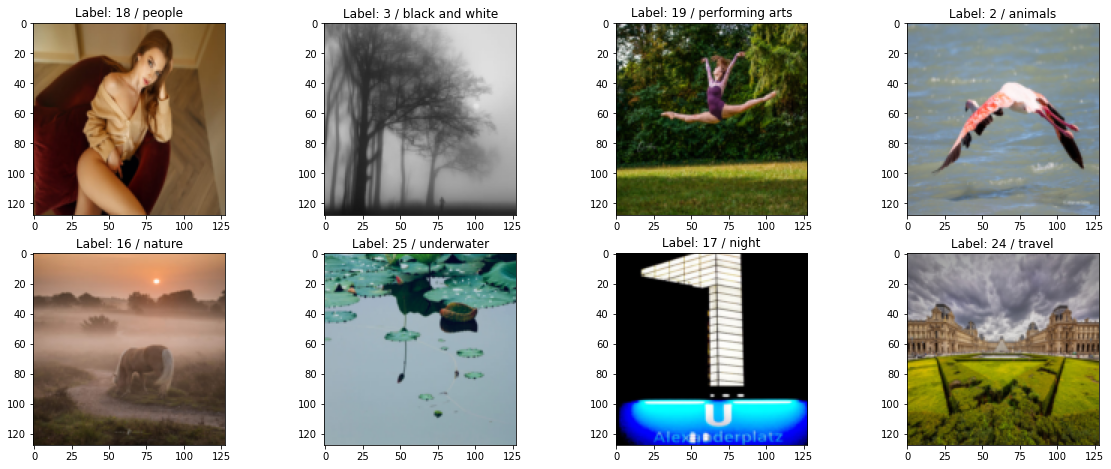

In [15]:
plot_images_from_loader(images_from_loader=images, labels=labels, amount=8, ncol=4)

### Pre-Processing

In [16]:
# Define a Composal of image transformation used for image load
transform_images = Compose([Resize((227, 227)), 
                            ToTensor(),
                            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [17]:
train_data = ImageFolder("data/train", transform=transform_images)
test_data = ImageFolder("data/test", transform=transform_images)

In [18]:
dataloader_train = DataLoader(train_data, batch_size=150, shuffle=True, 
                              num_workers=24, pin_memory=True)
dataloader_test = DataLoader(test_data, batch_size=150, shuffle=True, 
                             num_workers=24, pin_memory=True)

## S3: Varying Stride Sizes

#### Low Stride Implementation

In [19]:
from networks import FlatAlexNetLS, FlatAlexNetHS

In [11]:
model_losses = {}
model_acc = {}
model_train_test_metrics = {}

In [12]:
model_losses['FlatAlexNetLS'] = {}
model_acc['FlatAlexNetLS'] = {}
model_train_test_metrics['FlatAlexNetLS'] = {}

In [20]:
ls_model = FlatAlexNetLS(n_classes=28)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ls_model.parameters(), lr=.001, momentum=.95)
dtype = torch.float32

In [21]:
print_total_params(ls_model)

Trainable Parameters: 373287708


In [ ]:
ls_model, losses = train_network(model=ls_model, criterion=criterion, 
                                            optimizer=optimizer, dataloader_train=dataloader_train, 
                                            n_epochs=5)

In [38]:
model_losses['FlatAlexNetLS'] = losses
model_acc['FlatAlexNetLS'] = train_acc

In [ ]:
metrics = calculate_metrics(dl_train=dataloader_train, dl_test=dataloader_test, model=ls_model)
print('Train Accuracy / Test Accuracy: ', metrics['accuracy'],
      '\nTrain Precision / Test Precision: ', metrics['precision'])

In [40]:
model_train_test_metrics['FlatAlexNetLS']['acc'] = metrics['accuracy']
model_train_test_metrics['FlatAlexNetLS']['prec'] = metrics['precision']

In [ ]:
y_true, y_pred = network_predict(model=ls_model, dataloader=dataloader_test)

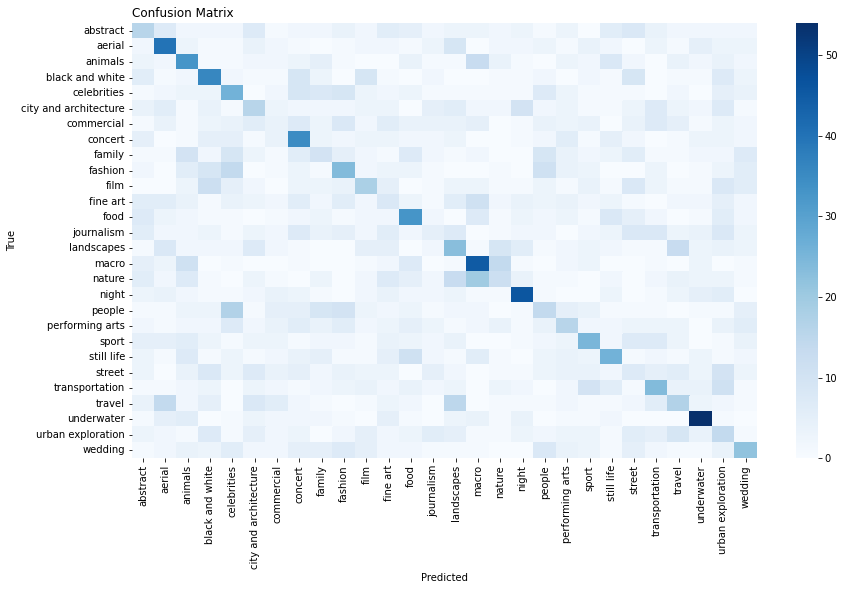

In [43]:
plot_confusion_matrix(y_true, y_pred)

#### High Stride Implementation

In [44]:
model_losses['FlatAlexNetHS'] = {}
model_acc['FlatAlexNetHS'] = {}
model_train_test_metrics['FlatAlexNetHS'] = {}

In [25]:
hs_model = FlatAlexNetHS(n_classes=28)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(hs_model.parameters(), lr=.002, momentum=.95)
dtype = torch.float32

In [ ]:
hs_model, losses = train_network(model=hs_model, criterion=criterion, 
                                optimizer=optimizer, dataloader_train=dataloader_train, 
                                n_epochs=50)

In [60]:
model_losses['FlatAlexNetHS'] = losses
model_acc['FlatAlexNetHS'] = train_acc

In [61]:
metrics = calculate_metrics(dl_train=dataloader_train, dl_test=dataloader_test, model=hs_model)
print('Train Accuracy / Test Accuracy: ', metrics['accuracy'],
      '\nTrain Precision / Test Precision: ', metrics['precision'])

Calculate Acc. on Test Data: 100%|██████████| 19/19 [00:03<00:00,  5.36it/s]

Train Accuracy / Test Accuracy:  [0.9942537783375315, 0.23087768769827283] 
Train Precision / Test Precision:  [0.9943207487310016, 0.23485940836084734]


In [62]:
model_train_test_metrics['FlatAlexNetHS']['acc'] = metrics['accuracy']
model_train_test_metrics['FlatAlexNetHS']['prec'] = metrics['precision']

In [63]:
y_true, y_pred = network_predict(model=hs_model, dataloader=dataloader_test)

Calculate Acc. on Test Data: 100%|██████████| 19/19 [00:03<00:00,  5.47it/s]


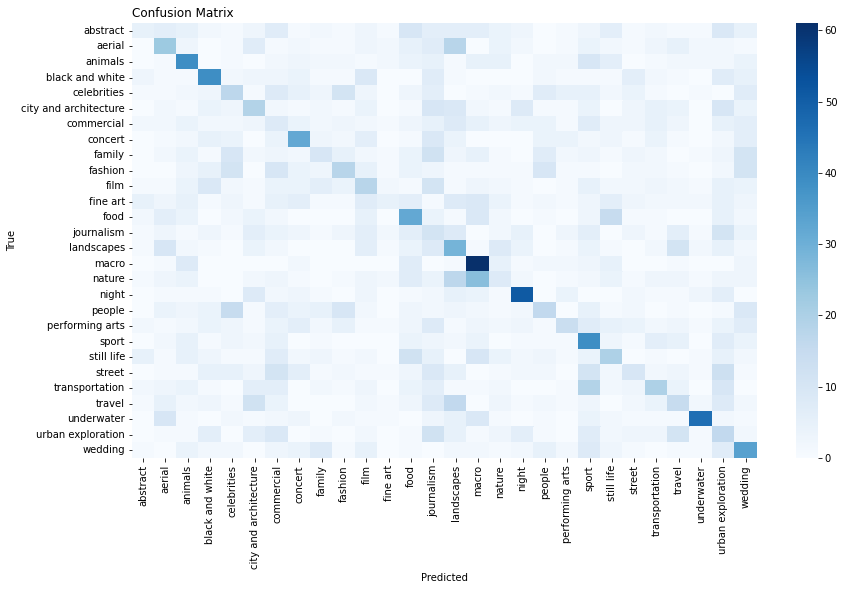

In [64]:
plot_confusion_matrix(y_true, y_pred)

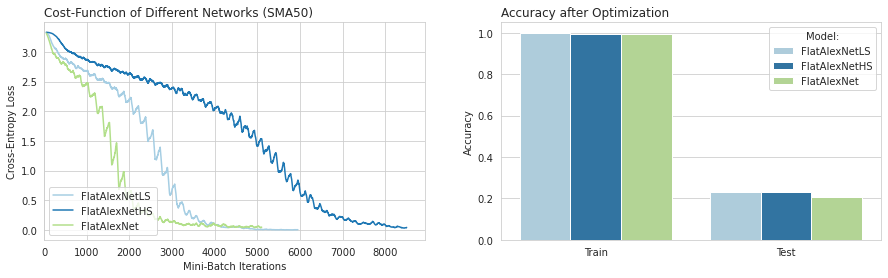

In [25]:
# load results
with open('./src/model_losses_stride.pkl', 'rb') as pkl_file:
    model_losses = pickle.load(pkl_file)
with open('./src/model_acc_stride.pkl', 'rb') as pkl_file:
    model_acc = pickle.load(pkl_file)
with open('./src/model_train_test_acc_stride.pkl', 'rb') as pkl_file:
    model_train_test_metrics = pickle.load(pkl_file)
    
with open('./src/model_losses.pkl', 'rb') as pkl_file:
    model_losses['FlatAlexNet'] = pickle.load(pkl_file)['FlatAlexNet']
with open('./src/model_acc.pkl', 'rb') as pkl_file:
    model_acc['FlatAlexNet'] = pickle.load(pkl_file)['FlatAlexNet']
with open('./src/model_train_test_acc.pkl', 'rb') as pkl_file:
    model_train_test_metrics['FlatAlexNet'] = pickle.load(pkl_file)['FlatAlexNet']

# Transform
model_losses = pd.DataFrame.from_dict(model_losses, orient='index').T
model_acc = pd.DataFrame.from_dict(model_acc)
tmp = pd.DataFrame.from_dict(model_train_test_metrics)

train_test_metrics = pd.DataFrame()
for col in tmp.columns:
    tmp_ = tmp.explode(column=col)[col]
    tmp_.index = ['Train Accuracy', 'Test Accuracy', 'Train Precision', 'Test Precision']
    train_test_metrics = pd.concat([train_test_metrics, tmp_], axis=1)
tmp = train_test_metrics.reset_index()

tmp = tmp[tmp['index'].str.contains('Accuracy')]
tmp = pd.melt(tmp, id_vars=['index'])

#Plot 
plot_evaluation_networks(losses=model_losses, 
                         accuracy=tmp, 
                         key_names=model_losses.columns.to_list(), sma=50)